In [1]:
from qiskit import IBMQ

In [2]:
IBMQ.load_account()
#IBMQ.providers()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(project='default')
backend = provider.get_backend('ibmq_armonk')
backend_config = backend.configuration()
print(backend_config.open_pulse)

True


In [4]:
backend_defaults = backend.defaults()
backend_defaults

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import pulse
from qiskit.circuit import Parameter
from qiskit.tools.monitor import job_monitor

# Qubit Frequency

In [312]:
qubit = 0
center_frequency_GHz = backend_defaults.qubit_freq_est[qubit] * 1e-9
print('Default frquency = ', center_frequency_GHz, 'GHz')
scale_factor = 1e-14
frequency_span_GHz = 20 * 1e-3
frequency_step_GHz = 1e-3

# frequency sweep range
frequencies_GHz = np.arange(center_frequency_GHz - frequency_span_GHz,
                            center_frequency_GHz + frequency_span_GHz, frequency_step_GHz)
print('frequency sweep range : ', center_frequency_GHz - frequency_span_GHz,
     '~', center_frequency_GHz + frequency_span_GHz, 'GHz')

drive_sigma_sec = 75 * 1e-9
drive_duration_sec = drive_sigma_sec * 8
drive_amp = .05

Default frquency =  4.971624719294304 GHz
frequency sweep range :  4.951624719294305 ~ 4.991624719294304 GHz


In [7]:
freq = Parameter('freq')

with pulse.build(backend=backend, default_alignment='sequential', name='Frequency Sweep') as sweep_sched : 
    drive_duration = pulse.seconds_to_samples(drive_duration_sec)
    drive_duration = int(drive_duration + 8) - (int(drive_duration + 8) % 16)
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    
    pulse.play(pulse.Gaussian(duration=drive_duration, sigma=drive_sigma, 
                              amp=drive_amp, name='freq_sweep_excitation_pulse'), 
                              drive_chan)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(0)])

In [8]:
frequencies_Hz = frequencies_GHz * 1e9
schedules = [sweep_sched.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

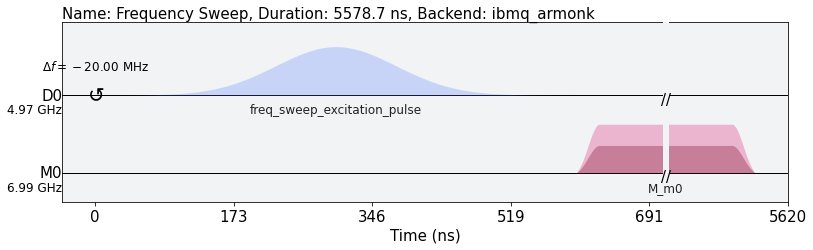

In [9]:
schedules[0].draw(backend=backend)

In [10]:
job = backend.run(schedules, meas_level=1, meas_return='avg', shots=1000)
job_monitor(job)
frequency_sweep_results = job.result()

Job Status: job has successfully run


In [11]:
sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    res = frequency_sweep_results.get_memory(i) * scale_factor
    sweep_values.append(res[qubit])
sweep_values

[(2.20250234683392+14.84907901616128j),
 (2.15782613057536+14.81155442376704j),
 (2.19609563136+14.80101833211904j),
 (2.1495564730368+14.8170466131968j),
 (2.20317377101824+14.8285020962816j),
 (2.17004430589952+14.86399731662848j),
 (2.28235870732288+14.80519652999168j),
 (2.173681270784+14.83841675984896j),
 (2.16874440720384+14.83488549142528j),
 (2.27278193688576+14.84918370598912j),
 (2.12021949759488+14.78697915777024j),
 (2.15930219003904+14.86642799968256j),
 (2.1940521664512+14.82790214303744j),
 (2.16916719304704+14.79263911936j),
 (2.18508004687872+14.90867302957056j),
 (2.16778609262592+14.83996697460736j),
 (2.15484112830464+14.89221659394048j),
 (2.05826023227392+14.901556805632j),
 (1.63558931300352+14.89750611460096j),
 (0.98924035571712+14.99302350290944j),
 (0.61869310083072+14.87003845656576j),
 (1.17627510849536+14.92761249316864j),
 (1.59894300786688+14.9212733898752j),
 (1.9700587167744+14.9109721792512j),
 (2.08668419162112+14.9159986331648j),
 (2.20136518713344

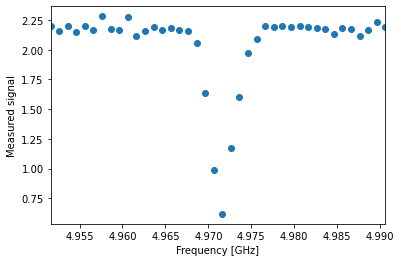

In [12]:
plt.scatter(frequencies_GHz, np.real(sweep_values))
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal")
plt.show()

In [13]:
from scipy.optimize import curve_fit

In [14]:
def Lorentzian(x, K, A, q_freq, C):
    return (K / (np.pi*A)) * (A**2 / ((x - q_freq)**2 + A**2)) + C

params, params_covariance = curve_fit(Lorentzian, frequencies_GHz, np.real(sweep_values), [0.1, -0.1, 5.22, 3])
params

array([ 7.17630987e-03, -1.37437349e-03,  4.97154194e+00,  2.22178632e+00])

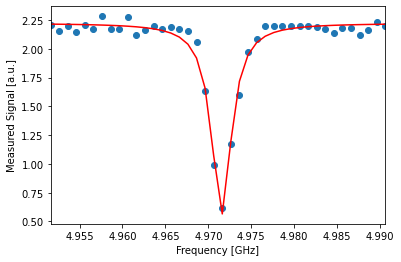

rough qubit frequency ~  4.971541937520409 GHz


In [15]:
plt.scatter(frequencies_GHz, np.real(sweep_values))
plt.plot(frequencies_GHz, Lorentzian(frequencies_GHz, params[0], params[1], params[2], params[3]),color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()
rough_qubit_frequency= params[2] * 1e9
print('rough qubit frequency ~ ', rough_qubit_frequency/1e9, 'GHz')

# Rabi Oscillation

In [17]:
print('rough qubit frequency = ', rough_qubit_frequency, 'Hz')
num_rabi_points = 50
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

rough qubit frequency =  4971541937.520409 Hz


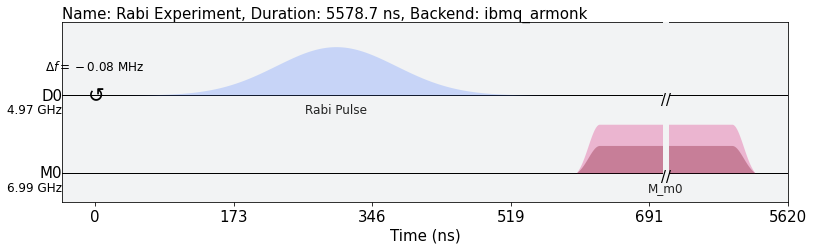

In [18]:
drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = pulse.seconds_to_samples(drive_duration_sec)
    drive_duration = int(drive_duration + 8) - (int(drive_duration + 8) % 16)
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(0)])

rabi_schedules = [rabi_sched.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

rabi_schedules[-1].draw(backend=backend)

In [19]:
job = backend.run(rabi_schedules, meas_level=1, meas_return='avg', shots=1000)
job_monitor(job)
rabi_results = job.result()

Job Status: job has successfully run


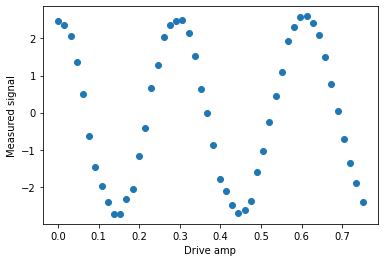

In [20]:
def baseline_remove(values):
    return np.array(values) - np.mean(values)

rabi_values = []
for i in range(num_rabi_points):
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp")
plt.ylabel("Measured signal")
plt.scatter(drive_amps, rabi_values)
plt.show()

In [96]:
def sinusoidal(x, A, B, drive_period, phi):
    return A*np.cos(2*np.pi*x/drive_period - phi) + B

params, params_covariance = curve_fit(sinusoidal, drive_amps, rabi_values, [2.5, 0.3, 9, 2.5])
params

array([-2.64050542,  0.00586835, -0.30968679,  3.40451594])

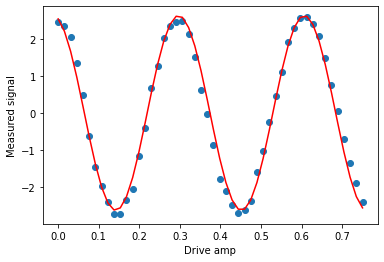

pi amplitude =  0.1548433970092217


In [97]:
plt.xlabel("Drive amp")
plt.ylabel("Measured signal")
plt.scatter(drive_amps, rabi_values)
plt.plot(drive_amps, sinusoidal(drive_amps, params[0], params[1], params[2], params[3]), color='red')
drive_period = params[2]
pi_amp = abs(drive_period / 2)
plt.show()
print('pi amplitude = ',pi_amp)

# Readout Fidelity

In [98]:
with pulse.build(backend) as pi_pulse:
    drive_duration = pulse.seconds_to_samples(drive_duration_sec)
    drive_duration = int(drive_duration + 8) - (int(drive_duration + 8) % 16)
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

In [99]:
print(backend_config.dt*1e9)

0.2222222222222222


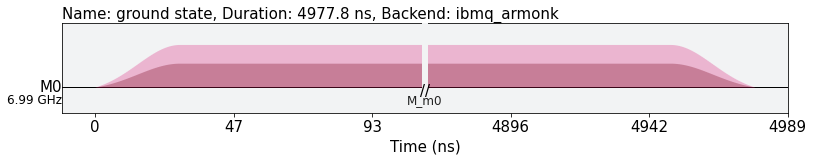

In [100]:
# Ground state schedule
with pulse.build(backend=backend, default_alignment='sequential', name='ground state') as gnd_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(0)])
    
gnd_schedule.draw(backend=backend)

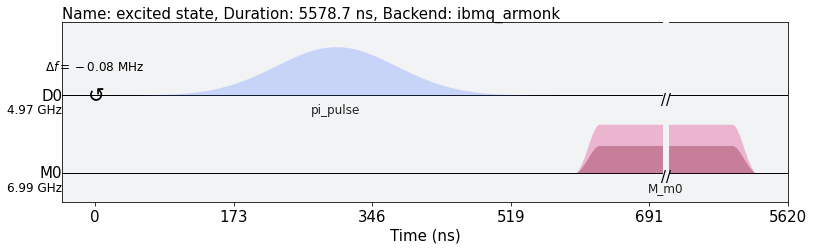

In [101]:
# Excited state schedule
with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(0)])
    
exc_schedule.draw(backend=backend)

In [102]:
job = backend.run([gnd_schedule, exc_schedule], meas_level=1, 
                  meas_return='single', shots=1000)
job_monitor(job)
gnd_exc_results = job.result()

Job Status: job has successfully run


In [105]:
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

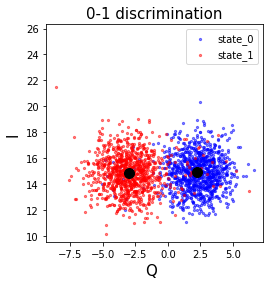

In [106]:
plt.figure()

# Plot all the results

plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')

plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

plt.axis('square')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) 
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=100, cmap='viridis', c='black',alpha=1.0)
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=100, cmap='viridis', c='black',alpha=1.0)

plt.ylabel('I ', fontsize=15)
plt.xlabel('Q ', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)
plt.legend()

plt.show()

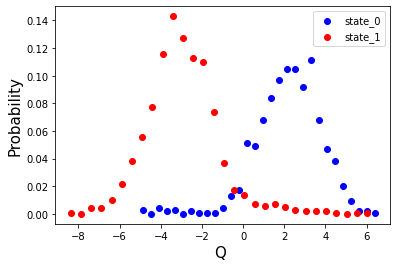

[-5.03272759 -4.64474439 -4.25676119 -3.86877799 -3.4807948  -3.0928116
 -2.7048284  -2.3168452  -1.92886201 -1.54087881 -1.15289561 -0.76491241
 -0.37692922  0.01105398  0.39903718  0.78702038  1.17500357  1.56298677
  1.95096997  2.33895317  2.72693636  3.11491956  3.50290276  3.89088596
  4.27886915  4.66685235  5.05483555  5.44281875  5.83080194  6.21878514
  6.60676834]
[-8.62628881 -8.1297971  -7.63330539 -7.13681368 -6.64032197 -6.14383026
 -5.64733855 -5.15084684 -4.65435513 -4.15786342 -3.66137171 -3.16488
 -2.66838829 -2.17189658 -1.67540487 -1.17891316 -0.68242145 -0.18592974
  0.31056197  0.80705368  1.30354539  1.8000371   2.29652881  2.79302052
  3.28951223  3.78600394  4.28249565  4.77898736  5.27547907  5.77197078
  6.26846249]


In [292]:
def edge_to_x(edge):
        x = np.empty(len(edge)-1)
        for i in range(len(x)):
            x[i] = 0.5*(edge[i] + edge[i+1])
        return x

Q = np.real(gnd_results)
y0, edge0 = np.histogram(Q,bins= 30)
x0 = edge_to_x(edge0)
y0 = y0.astype(float)
y0 /= sum(y0)

Q = np.real(exc_results)
y1, edge1 = np.histogram(Q,bins= 30)
x1 = edge_to_x(edge1)    
y1 = y1.astype(float)
y1 /= sum(y1)

plt.figure()
plt.scatter(x0,y0, color='blue', label='state_0')
plt.scatter(x1,y1, color='red', label='state_1')
plt.ylabel('Probability', fontsize=15)
plt.xlabel('Q ', fontsize=15)
plt.legend()
plt.show()
print(edge0)
print(edge1)

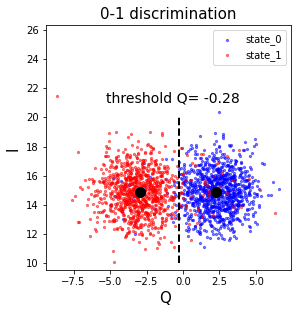

-0.28


In [306]:
threshold = np.round(0.5*(-0.37692922 - 0.18592974),2)

#plt.figure()
fig, ax = plt.subplots(1, figsize=(4.5, 4.5))
# Plot all the results

plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')

plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

plt.axis('square')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) 
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=100, cmap='viridis', c='black',alpha=1.0)
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=100, cmap='viridis', c='black',alpha=1.0)

plt.plot([threshold, threshold], [10, 20], 'k--', lw=2)
ax.text(threshold-5, 21, f"threshold Q= {threshold} ",fontsize=14)
plt.ylabel('I ', fontsize=15)
plt.xlabel('Q ', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)
plt.legend()

plt.show()
print(threshold)

In [307]:
# return 1 if point is close to excited state, 0 if point is closer to ground state
def classify(point: complex):
    def distance(a, b):
        return np.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int( distance(point, mean_exc) < distance(point, mean_gnd) )

In [313]:
#point wrong side
wrong1 = sum(map(classify, gnd_results))
wrong2 = len(gnd_results) - sum(map(classify, exc_results))

total = len(gnd_results) + len(exc_results)

pe = (wrong1 + wrong2) / total
print('readout error rate = ', pe)

readout error rate =  0.0435


## T1 Decay Time

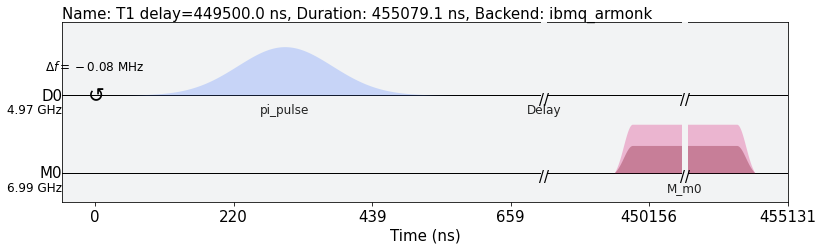

In [309]:
time_max_sec = 450 * 1e-6
time_step_sec = 6.5 * 1e-6
delay_times_sec = np.arange(1 * 1e-6, time_max_sec, time_step_sec)

t1_schedules = []
for delay in delay_times_sec:
    with pulse.build(backend=backend, default_alignment='sequential', name= f"T1 delay={delay*1e9} ns") as t1_schedule:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(rough_qubit_frequency, drive_chan)
        pulse.call(pi_pulse)
    
        delay_sample = pulse.seconds_to_samples(delay)
        delay_sample = int(delay_sample + 8) - (int(delay_sample + 8) % 16)
        pulse.delay(delay_sample, drive_chan)
        pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(0)])
    t1_schedules.append(t1_schedule)

t1_schedules[-1].draw(backend=backend)

In [310]:
job = backend.run(t1_schedules, meas_level=1, 
                  meas_return='single', shots=250)
job_monitor(job)
t1_results = job.result()

Job Status: job has successfully run


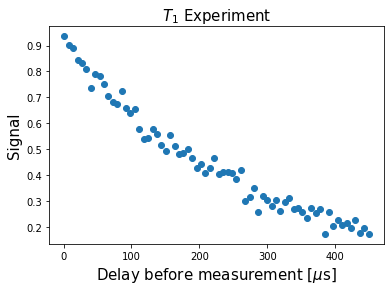

In [314]:
t1_values = []

for i in range(len(delay_times_sec)):
    iq_data = t1_results.get_memory(i)[:,qubit] * scale_factor
    t1_values.append(sum(map(classify, iq_data)) / 250)
    
plt.scatter(delay_times_sec/1e-6, t1_values) 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal', fontsize=15)
plt.show()

In [315]:
def exponential_decay(x, A, T1, C):
    return A * np.exp(-x / T1) + C

params, params_covariance = curve_fit(exponential_decay, delay_times_sec/1e-6, t1_values, [2, 1.0, 0.5])
params

array([8.93285354e-01, 2.61518551e+02, 2.72267556e-02])

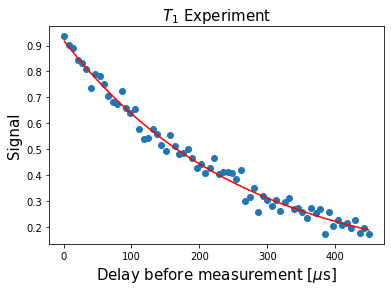

T1 =  261.519 μs


In [316]:
plt.scatter(delay_times_sec/1e-6, t1_values) 
plt.plot(delay_times_sec/1e-6,exponential_decay(delay_times_sec/1e-6, params[0], params[1], params[2]), color='red')
T1 = np.round(params[1],3)
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal', fontsize=15)
plt.show()
print('T1 = ', T1, 'μs')

## Ramsey oscillation (calibration)

In [319]:
drive_amp = pi_amp / 2

with pulse.build(backend) as x90_pulse:
    drive_duration = pulse.seconds_to_samples(drive_duration_sec)
    drive_duration = int(drive_duration + 8) - (int(drive_duration + 8) % 16)
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

In [320]:
detuning_Hz = 2*1e6 
ramsey_frequency = round(rough_qubit_frequency + detuning_Hz, 6) # need ramsey freq in Hz

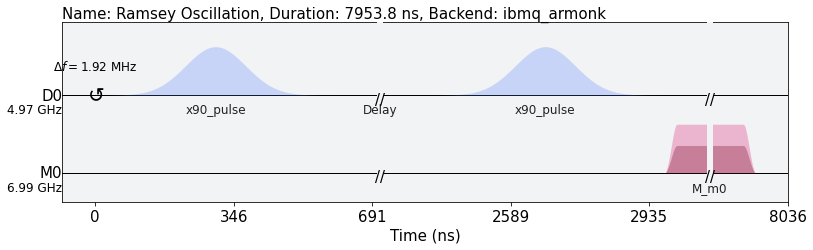

In [321]:
time_max_sec = 1.8 * 1e-6
time_step_sec = 0.025 * 1e-6
delay_times_sec = np.arange(0.1 * 1e-6, time_max_sec, time_step_sec)

ramsey_schedules = []
for delay in delay_times_sec:
    with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey Oscillation") as ramsey_schedule:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(ramsey_frequency, drive_chan)
        pulse.call(x90_pulse)
    
        delay_sample = pulse.seconds_to_samples(delay)
        delay_sample = int(delay_sample + 8) - (int(delay_sample + 8) % 16)
        pulse.delay(delay_sample, drive_chan)
    
        pulse.call(x90_pulse)
        pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(0)])
    
    ramsey_schedules.append(ramsey_schedule)

ramsey_schedules[-1].draw(backend=backend)

In [322]:
job = backend.run(ramsey_schedules, meas_level=1, 
                  meas_return='single', shots=500)
job_monitor(job)
ramsey_results = job.result()

Job Status: job has successfully run


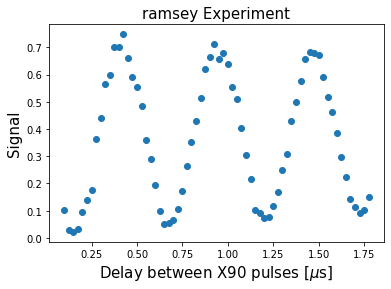

In [324]:
ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / 500)
    
plt.scatter(delay_times_sec/1e-6, np.real(ramsey_values)) 
plt.title("ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Signal', fontsize=15)
plt.show()

In [344]:
def sinusoidal(x, A, del_f_MHz, B, C):
    return A * np.cos(2*np.pi*del_f_MHz*x - B) + C

params, params_covariance = curve_fit(sinusoidal, delay_times_sec/1e-6, ramsey_values, [3, 1.5, 0.5, 0.3])
params

array([-0.31978995,  1.89995744,  1.82918937,  0.37957895])

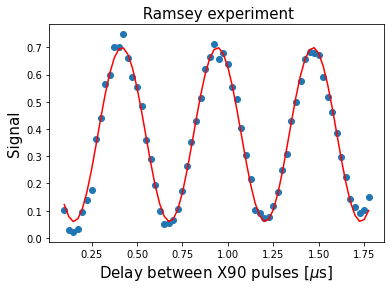

del_f_MHz =  1.899957437734017 MHz


In [345]:
plt.scatter(delay_times_sec/1e-6,  ramsey_values) 
plt.plot(delay_times_sec/1e-6,sinusoidal(delay_times_sec/1e-6, params[0], params[1], params[2], params[3]), color='red')
del_f_MHz = params[1]
plt.title(" Ramsey experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Signal', fontsize=15)
plt.show()
print('del_f_MHz = ', del_f_MHz, 'MHz')

In [347]:
detuning_MHz = detuning_Hz/1e6
precise_qubit_freq = rough_qubit_frequency + (del_f_MHz - detuning_MHz) * 1e6 
print(f"Precise qubit frequency is now {round(precise_qubit_freq/1e9, 6)} GHz. "
      f"It used to be {round(rough_qubit_frequency / 1e9, 6)} GHz")

Precise qubit frequency is now 4.971442 GHz. It used to be 4.971542 GHz


## T2 Dephasing Time

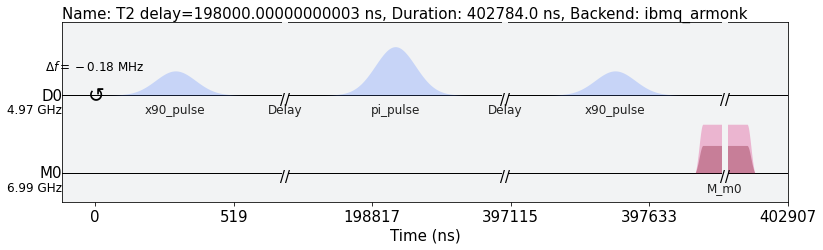

In [348]:
time_max_sec = 200 * 1e-6
time_step_sec = 4.0 * 1e-6
delay_times_sec = np.arange(2.0 * 1e-6, time_max_sec, time_step_sec)

t2_schedules = []
for delay in delay_times_sec:
    with pulse.build(backend=backend, default_alignment='sequential', name=f"T2 delay={delay*1e9} ns") as t2_schedule:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(precise_qubit_freq, drive_chan)
        pulse.call(x90_pulse)
    
        delay_sample = pulse.seconds_to_samples(delay)
        delay_sample = int(delay_sample + 8) - (int(delay_sample + 8) % 16)
        pulse.delay(delay_sample, drive_chan)
    
        pulse.call(pi_pulse)
    
        delay_sample = pulse.seconds_to_samples(delay)
        delay_sample = int(delay_sample + 8) - (int(delay_sample + 8) % 16)
        pulse.delay(delay_sample, drive_chan)
    
        pulse.call(x90_pulse)
        pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(0)])
    
    t2_schedules.append(t2_schedule)

t2_schedules[-1].draw(backend=backend)

In [349]:
job = backend.run(t2_schedules, meas_level=1, 
                  meas_return='single', shots=500)
job_monitor(job)
t2_results = job.result()

Job Status: job has successfully run


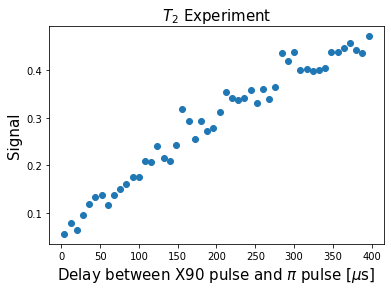

In [350]:
t2_values = []

for i in range(len(delay_times_sec)):
    iq_data = t2_results.get_memory(i)[:,qubit] * scale_factor
    t2_values.append(sum(map(classify, iq_data)) / 500)
    
plt.scatter(2*delay_times_sec/1e-6, t2_values) 
plt.title("$T_2$ Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Signal', fontsize=15)
plt.show()

In [351]:
def exponential_decay(x, A, T2, C):
    return A * np.exp(-x / T2) + C

params, params_covariance = curve_fit(exponential_decay, 2*delay_times_sec/1e-6, t2_values, [-3, 210, 0.0])
params

array([ -0.66389917, 400.27885807,   0.71025957])

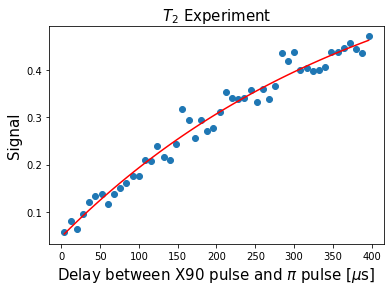

T2 =  400.279 μs


In [352]:
plt.scatter(2*delay_times_sec/1e-6, t2_values) 
plt.plot(2*delay_times_sec/1e-6,exponential_decay(2*delay_times_sec/1e-6, params[0], params[1], params[2]), color='red')
T2 = np.round(params[1],3)
plt.title("$T_2$ Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Signal', fontsize=15)
plt.show()
print('T2 = ', T2, 'μs')

## T2*

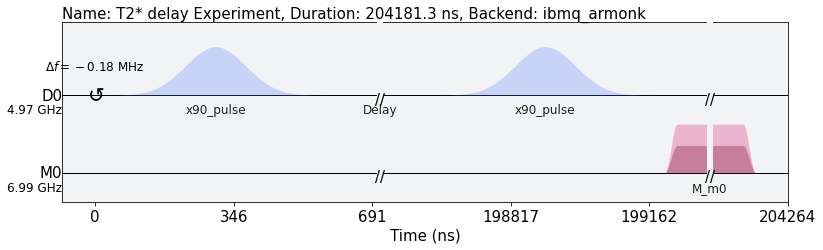

In [353]:
time_max_sec = 200 * 1e-6
time_step_sec = 4 * 1e-6
delay_times_sec = np.arange(2 * 1e-6, time_max_sec, time_step_sec)

t2star_schedules = []
for delay in delay_times_sec:
    with pulse.build(backend=backend, default_alignment='sequential', name="T2* delay Experiment") as t2star_schedule:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(precise_qubit_freq, drive_chan)
        pulse.call(x90_pulse)
    
        delay_sample = pulse.seconds_to_samples(delay)
        delay_sample = int(delay_sample + 8) - (int(delay_sample + 8) % 16)
        pulse.delay(delay_sample, drive_chan)
    
        pulse.call(x90_pulse)
        pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(0)])
    
    t2star_schedules.append(t2star_schedule)

t2star_schedules[-1].draw(backend=backend)

In [354]:
job = backend.run(t2star_schedules, meas_level=1, 
                  meas_return='single', shots=1000)
job_monitor(job)
t2star_results = job.result()

Job Status: job has successfully run


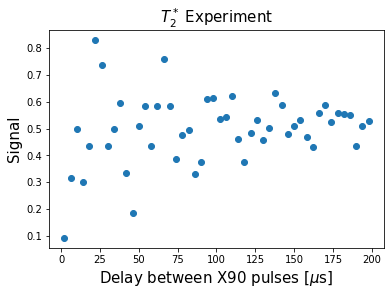

In [356]:
t2star_values = []

for i in range(len(delay_times_sec)):
    iq_data = t2star_results.get_memory(i)[:,qubit] * scale_factor
    t2star_values.append(sum(map(classify, iq_data)) / 1000)
    
plt.scatter(delay_times_sec/1e-6, np.real(t2star_values)) 
plt.title("$T_2^*$ Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Signal', fontsize=15)
plt.show()

In [357]:
def exponential_decay(x, A, T2, C):
    return A * np.exp(-x / T2) + C

params, params_covariance = curve_fit(exponential_decay, delay_times_sec/1e-6, t2star_values, [3, 100, 0.2])
params

array([-0.63958834,  4.87595006,  0.5146242 ])

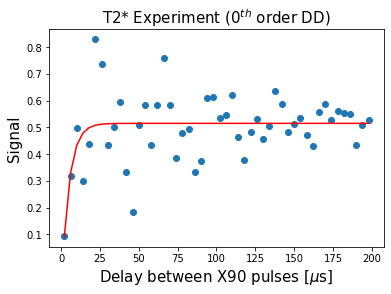

T2* =  4.875950055683215 μs


In [358]:
plt.scatter(delay_times_sec/1e-6, t2star_values) 
plt.plot(delay_times_sec/1e-6,exponential_decay(delay_times_sec/1e-6, params[0], params[1], params[2]), color='red')
T2star= params[1]
plt.title("T2* Experiment ($0^{th}$ order DD)", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Signal', fontsize=15)
plt.show()
print('T2* = ', T2star, 'μs')